## Getting the Most out of the Imputer Classes
---
This tutorial gives users a comprehensive overview of `Autoimpute` Imputers. It includes:
* Motivation for Imputation in the First Place
* The Design Considerations behind Imputers
* How the `SingleImputer` works under the Hood
* How the `MultipleImputer` works under the Hood
* Some hidden features, tips, and tricks to get the most out of your imputers
* Additional features we're adding to the package

### Motivation for Imputation in the First Place
---
Let's revisit why multiple imputation is necessary in the first place. A user wants to perform analysis on a dataset using some sort of **analysis model** such as linear regression or logistic regression. The dataset of interest contains one or more predictors, $X$, and some response $y$. The analysis model produces a function that best explains the relationship between $X$ and $y$. Let's generate some sample data below. To keep things simple, our data set contains just one predictor, $x$, and a response $y$.

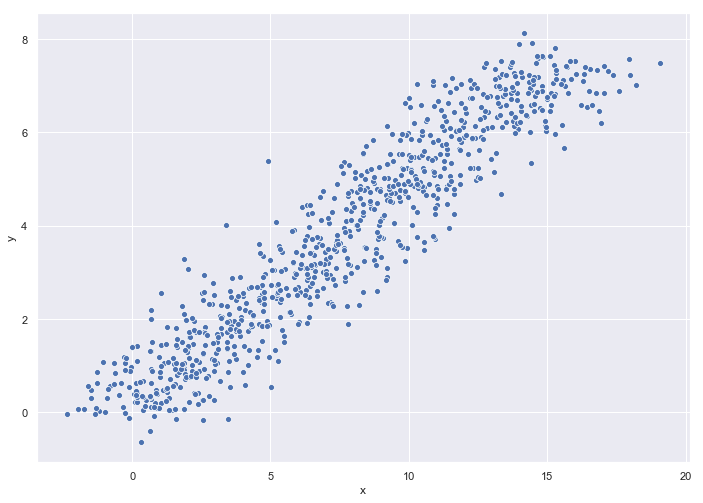

In [1]:
# imports
import numpy as np
import pandas as pd
from scipy.stats import norm, binom
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

# helper functions used throughout this project
print_header = lambda msg: print(f"{msg}\n{'-'*len(msg)}")

# seed to follow along
np.random.seed(654654)

# generate 1500 data points
N = np.arange(1500)

# helper function for this data
vary = lambda v: np.random.choice(np.arange(v))

# create correlated, random variables
a = 2
b = 1/2
eps = np.array([norm(0, vary(50)).rvs() for n in N])
y = (a + b*N + eps) / 100                         
x = (N + norm(10, vary(250)).rvs(len(N))) / 100
 
# 20% missing in x, 30% missing in y
x[binom(1, 0.2).rvs(len(N)) == 1] = np.nan
y[binom(1, 0.3).rvs(len(N)) == 1] = np.nan

# collect results in a dataframe 
data_miss = pd.DataFrame({"y": y, "x": x})
sns.scatterplot(x="x", y="y", data=data_miss)
plt.show()

The plot suggests a linear relationship exists between $x$ and $y$. Let's fit a linear model to estimate that relationship.

In [2]:
from sklearn.linear_model import LinearRegression

# prep for regression
X = data_miss.x.values.reshape(-1, 1) # reshape because one feature only
y = data_miss.y
lm = LinearRegression()

# try to fit the model
print_header("Fitting linear model to estimate relationship between X and y")
try:
    lm.fit(X, y)
except ValueError as ve:
    print(f"{ve.__class__.__name__}: {ve}")

Fitting linear model to estimate relationship between X and y
-------------------------------------------------------------
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').


#### What Happened?
<div>Note that we've removed the error's traceback, but sklearn threw a ValueError when we tried to fit a linear regression. The error occurred because our <b>dataset has missing data in a predictor, response, or both</b>. sklearn is unable to fit the analysis model unless the dataset it is provided is complete! That's no good - now we can't model the relationship in our data, nor can we make predictions when new data arrives.</div>

#### What do we Do?
<div>In order to proceed, we <b>need to handle the missing data in some way</b>. One option is simply removing records with missing data. This strategy allows the model to run, but it could introduce a number of complicated problems downstream. These problems will be addressed in another tutorial, but for now we'll recommend against dropping missing records.</div>
<br>

<div>If we don't drop missing records, <b>then we must impute them</b>. <em>Imputing</em> data means coming up with plausible values to fill in for missing records so that we can run our analysis model. <b>Performing imputations is the primary concern of this python package</b>. There's a tremendous amount to consider when imputing missing data, from the imputation model to use to that model's affect on the results analysis model. We'll address these considerations and how Autoimpute handles them in another tutorial. For now, we'll simply introduce the Imputers themselves and familiarize the reader with the package design.</div>

### The Design Considerations behind Imputers
---
<div>We designed Autoimpute Imputers with three goals in mind:</div>
<ol>
    <li><b>Make Imputation Easy</b>. Imputation can be done in one line of code.</li>
    <li><b>Make Imputation Familiar to Python Users</b>. Autoimpute Imputers follows the design patterns of sklearn.</li>
    <li><b>Make Imputation Flexible</b>. Use an Imputer's default arguments or fine-tune them case-by-case.</li>
</ol>
<br>
Let's explore how each goal is satisfied. We'll use the same dataset as above and stick with the `SingleImputer` for now. The `MutlipleImputer` extends the `SingleImputer` and therefore contains all the arguments that the `SingleImputer` does. Therefore, we will explain design considerations with the `SingleImputer`, and later on explain the additional arguments of the `MultipleImputer`

#### 1. Make Imputation Easy
<div>As promised, we can impute a dataset with exactly one line of code. But behind the scenes, a lot happens to make that possible. In the code section below, we'll explore what the one line of code actually does under the hood. First, we'll observe how many records are missing. Then, we'll perform imputation and verify that missing records have been imputed. By the way, disregard the output from the imputation for now. We'll address that soon.</div>

In [3]:
# amount of missing data before imputation
before_imp = pd.DataFrame(data_miss.isnull().sum(), columns=["records missing"]).T
before_imp

,x,y
records missing,285,491


In [5]:
from autoimpute.imputations import SingleImputer
data_imputed_once = SingleImputer().fit_transform(data_miss)

In [6]:
# amount of missing data before imputation
after_imp = pd.DataFrame(data_imputed_once.isnull().sum(), columns=["records missing"]).T
after_imp

,x,y
records missing,0,0


#### 2. Make Imputation Familiar to Python Users
<div>Autoimpute follows sklearn API design. This design choice comes with a number of benefits:</div>
<ul>
    <li>If you are familiar with sklearn, there is essentially no learning curve to start using Autoimpute.</li>
    <li>Imputers inherit important methods from Parent classes, such as `__repr__` and get_params from BaseEstimator.</li>
    <li>Imputers can "fit_transform" the same dataset, or "fit" and Imputer to transform new data at a later date.</li>
    <li>Imputers fit in sklearn Pipelines (although Autoimpute includes ML models designed for multiply imputed data).</li>
</ul>
The code segments below demonstrate Autoimpute's ease of use and familiarity.

First, Autoimpute Imputers inherit from `BaseEstimator` and `TransformerMixin` classes from `sklearn`. Additionally, Imputers implement `fit` and `transform` methods, making them valid `Transformers`. This inheritence makes Imputers intuitive to use for those familiar with `sklearn`, and it means that Imputers fit within `sklearn` `Pipelines`.

In [7]:
print_header("Parent Classes to SingleImputer and MultipleImpuer")
print(list(map(lambda cls_: cls_.__name__, SingleImputer().__class__.__bases__)))

Parent Classes to SingleImputer and MultipleImpuer
--------------------------------------------------
['BaseImputer', 'BaseEstimator', 'TransformerMixin']


Next, Autoimpute sets smart default values for all its arguments, making it very easy to get started with imputation. Useres can create an instance of an Imputer without passing any arguments. And because Imputers inherit from `BaseEstimator`, they can use its informative `__repr__` special method to see their Imputer and examine the default values.

In [8]:
SingleImputer()

SingleImputer(copy=True, imp_kwgs=None, predictors='all', scaler=None,
       seed=None, strategy='predictive default', verbose=False,
       visit='default')

Finally, Imputers are valid sklearn Transformers. They implement the `fit`, `transform`, and `fit_transform` methods, which should be familiar to anyone who has preprocessed data using sklearn. And as with sklearn, the transform step returns the ***transformed dataframe***. We demonstrate the process below. (Ignore any arguments for now).

In [9]:
print_header("Transforming the missing dataset with mean imputation")
imp = SingleImputer(strategy="mean").fit_transform(data_miss)
imp.head()

Transforming the missing dataset with mean imputation
-----------------------------------------------------


,x,y
0,2.534781,0.257901
1,-0.118755,-0.114591
2,-1.184612,0.018801
3,1.442059,0.047037
4,0.109537,0.229042


#### 3. Make Imputation Flexible
<div>To make Imputers powerful, we need to make them flexible. There are hundreds of imputation methods, each of which implements a different algorithm and requires a variable number of parameters. Some of these are simple, but some are quite complex. For example, consider two strategies:</div>
<ul>
    <li><b>Mean imputation</b>: univariate, requires no parameters. Easy!</li>
    <li><b>PMM imputation</b>: multivariate, requires multiple parameters. More complicated!</li>
</ul>
<br>
<div>And both of the methods above impute <b>one series only</b>. Fortunately, the Autoimpute Imputers' arguments give users full control of how to impute each column within a dataset. We'll show some examples below to get started. The practicality of Imputer arguments will become more clear in the following section regarding the Imputers under the hood.</div>

Let's observe the parameters within Imputers. The code below prints the argument name and its default value.

In [10]:
print_header("Printing arguments for the SingleImputer as well as their default values")
for k,v in SingleImputer().get_params().items():
    print(f"Argument: {k}; Default: {v}")

Printing arguments for the SingleImputer as well as their default values
------------------------------------------------------------------------
Argument: copy; Default: True
Argument: imp_kwgs; Default: None
Argument: predictors; Default: all
Argument: scaler; Default: None
Argument: seed; Default: None
Argument: strategy; Default: predictive default
Argument: verbose; Default: False
Argument: visit; Default: default


The `SingleImputer` arguments and their default values appear in the output of the code above. Below is a brief description of each argument. The rest of this tutorial will make it clear how these arguments give the user total control over the imputation process.
<ul>
    <li><b>copy</b>: Whether or not to copy the dataset during the transform place. If False, imputations happen in place.</li>
    <li><b>imp_kwgs</b>: Dictionary of arguments to fine-tune imputation on a specific column or for a specific imputation strategy.</li>
    <li><b>predictors</b>: Which columns to use to predict imputations for a given column being imputed.</li>
    <li><b>scaler</b>: An optional sklearn scaler, which will scale the data based on the type of scaler passed.</li>
    <li><b>seed</b>: Seed number makes imputations reproducible.</li>
    <li><b>strategy</b>: The imputation strategy to use. Can specify for all columns or each column individually.</li>
    <li><b>verbose</b>: Whether or not to print internals of imputation steps to the console.</li>
    <li><b>visit</b>: The order in which columns should be "visited" or imputed.</li>
</ul>

### How the SingleImputer works under the Hood
---
<div>A lot has to happen to satisfy our three design considerations addressed in the section above. This section explains how the SingleImputer works under the hood to make the imputation process easy, familiar, and flexible. In this section, we cover:</div>
<ul>
    <li>Instantiating a SingleImputer and Tuning its Parameters</li>
    <li>How the SingleImputer Fits the Imputation Model</li>
    <li>How the SingleImputer Tranforms Data to Return Imputations</li>
</ul>
<br>
<div>We'll demonstrate with the toy dataset created below. Note that the dataset has no missing values. This is fine because we will not perform any imputations. Rather, we will demonstrate how we can control an Imputer as we prepare to impute. Additionally, our dataframe has columns of mixed types. `Age`, `salary`, and `weight` are numeric, while `gender` is categorical (and in this case, binary).</div>

In [11]:
toy_df = pd.DataFrame({
    "gender": np.random.choice(["Male","Female"], 50),
    "age": np.random.choice(np.arange(20,80), 50),
    "salary": np.random.choice(np.arange(50_000, 1_000_000), 50),
    "weight": np.random.choice(np.arange(100, 300), 50),
})
toy_df.head()

,age,gender,salary,weight
0,28,Female,89740,135
1,46,Female,898345,205
2,60,Female,58695,218
3,61,Female,806925,273
4,58,Male,968180,286


#### Instantiating a SingleImputer and Tuning its Parameters
To get started in the code below, we create a `SingleImputer` and rely on all the default aguments.

In [12]:
SingleImputer()

SingleImputer(copy=True, imp_kwgs=None, predictors='all', scaler=None,
       seed=None, strategy='predictive default', verbose=False,
       visit='default')

The instantiation above makes it easy to get started with imputation. Additionally, this approach is familiar because `sklearn` classes operate the same way. But we can make our Imputer **much more customized and powerful by exploiting its flexibility**. To do so, we'll consider the arguments we can tweak to design the best imputation model.

<div><b><em><span style="color:navy">The strategy argument</span></em></b></div>
The `SingleImputer` sets default values for all its arguments as we discussed above. But let's see how we can tweak those arguments to make them more appropriate for our use case. First, let's review our options for setting the <b>strategy</b> used to impute each column. The list below shows all the strategies available to impute a column within a dataframe. The `predictive default` is the default if a user does not specify a strategy. It chooses the preferred strategy to use depending on a columns data type (`pmm` for numerical, `multinomial logistic` for categorical). Note that some of these strategies are for categorical data, while other are for numeric. As we'll see later, the Imputers let you know whether a strategy will work for a given column when you try to fit the imputation model.

In [13]:
print_header("Strategies Available for Imputation")
print(list(SingleImputer().strategies.keys()))

Strategies Available for Imputation
-----------------------------------
['predictive default', 'least squares', 'stochastic', 'binary logistic', 'multinomial logistic', 'bayesian least squares', 'bayesian binary logistic', 'pmm', 'univariate default', 'time default', 'mean', 'median', 'mode', 'random', 'norm', 'categorical', 'interpolate', 'locf', 'nocb']


We have a wealth of imputation methods at our disposal, and we continue to make more available. That being said, imputation is restricted to the list of strategies provided above. A user cannot even create an instance of an Imputer if the strategy he or she provides is unsupported. Improper strategy specification throws a `ValueError`, as shown below. Again, the traceback is removed to keep this tutorial clean, but the error below is clear. The `strategy` argument is validated when instantiating the class.

In [14]:
# proviging a strategy not yet supported or that doens't exist
print_header("Creating a SingleImputer with an unsupported strategy")
try:
    SingleImputer(strategy="unsupported")
except ValueError as ve:
    print(f"{ve.__class__.__name__}: {ve}")

Creating a SingleImputer with an unsupported strategy
-----------------------------------------------------
ValueError: Strategy unsupported not a valid imputation method.
 Strategies must be one of ['predictive default', 'least squares', 'stochastic', 'binary logistic', 'multinomial logistic', 'bayesian least squares', 'bayesian binary logistic', 'pmm', 'univariate default', 'time default', 'mean', 'median', 'mode', 'random', 'norm', 'categorical', 'interpolate', 'locf', 'nocb'].


<div>So how can utilize supported strategies? We can set the <b>strategy</b> in three ways:</div>
<ul>
    <li>As a <b>string</b>, which broadcasts the strategy across every column in the DataFrame</li>
    <li>As a <b>list or tuple</b>, where the position of strategies in the iterator are applied to the corresponding column</li>
    <li>As a <b>dictionary</b>, where the key is the column we want to impute, and the value is the strategy to use</li>
</ul>
<br>
<div>We advise the <b>dictionary method</b>, as it is the most explicit and allows the user to impute all or a subset of the columns in a dataframe. It is also the least prone to unexpected behavior and errors when trying to fit the imputation model. Let's look at some examples below, where we run into problems with the string and iterator method but have better control with the dictionary method.</div>

In [15]:
# string strategy broadcasts across all strategies
si_str = SingleImputer(strategy="mean")

# list strategies, where each item is a corresponding strategy
si_list1 = SingleImputer(strategy=["mean", "binary logistic", "categorical", "median"])
si_list2 = SingleImputer(strategy=["mean", "binary logistic", "median"])

# dictionary strategy, where we specify column and strategy together
# Note that with the dictionary, we can specify a SUBSET of columns to impute
si_dict = SingleImputer(strategy={"gender":"categorical", "salary": "pmm"})

<div>Note that we instantiated each SingleImputer with no issues yet. We provided valid types (string, iterator, or dictionary) for the strategy argument, and each strategy we provided is one of the strategies supported. So we are able to at least crete an instance of our class. <b>But that does not necessarily mean the strategies we've chosen will work with the columns of our DataFrame</b>. This is something we cannot validate <b>until the user fits the Imputer to a dataset</b> because the Imputer itself knows nothing about the dataset's columns or the column types until the Imputer is fit. We will see how this plays out below when we try to fit each imputer to our toy dataframe</div>

First, let's try to fit `si_str`, `si_list1`, and `si_list2`. All are valid Imputers but won't work with our toy data.

In [16]:
# fitting the string strategy, which yields an error
print_header("Fitting si_str, a SingleImputer that broadcasts strategy='mean'")
try:
    si_str.fit(toy_df)
except TypeError as te:
    print(f"{te.__class__.__name__}: {te}")

Fitting si_str, a SingleImputer that broadcasts strategy='mean'
---------------------------------------------------------------
TypeError: mean not appropriate for Series type object. Need numeric.


While a valid imputer, `si_str` failed to fit the dataset. The error tells us that the strategy is not appropriate for a Series with type object. This means that our strategy encountered a categorical column, and `mean` is not a valid strategy for categoricals! In our case, the Imputer was not able to take the mean of `gender`. Therefore, we must be very careful when setting the strategy as a string. We must ensure that we want the same strategy for each column, and we must ensure that our dataframe does not contain any columns that which the strategy cannot fit. As we'll see later, we could have specified `mean` for every column and ignored `gender` if we had used a dictionary. 

In [17]:
# fitting the string strategy, which yields an error
print_header("Fitting si_list1, a SingleImputer with a list of strategies to apply")
try:
    si_list1.fit(toy_df)
except TypeError as te:
    print(f"{te.__class__.__name__}: {te}")

Fitting si_list1, a SingleImputer with a list of strategies to apply
--------------------------------------------------------------------
TypeError: categorical not appropriate for Series type int64. Need categorical.


In [18]:
# fitting the string strategy, which yields an error
print_header("Fitting si_list2, a SingleImputer with a list of strategies to apply")
try:
    si_list2.fit(toy_df)
except ValueError as ve:
    print(f"{ve.__class__.__name__}: {ve}")

Fitting si_list2, a SingleImputer with a list of strategies to apply
--------------------------------------------------------------------
ValueError: Length of columns not equal to number of strategies.
Length of columns: 4
Length of strategies: 3


The two code segments above demonstrate some of the trouble setting strategies with lists. In `si_list1`, the problem is similar to the `mean` example. In `si_list1`, we specified the third strategy (index=2) as `categorical`. Theferfore, our imputer tried to fit `categorical` to the third column in `toy_df`, which is `salary`. Unfortunately, `salary` expects a numerical strategy, and `categorical` applies to categorical columns only. As a result, the imputer throws a `TypeError`.

With `si_list2`, a different problem occurs. If we use a list as the value to the `strategy` argument, the list must contain one strategy per column. When we created the imputer, the list contained 3 valid strategies, so no problem with instantiation. But when we tried to fit the dataset, the Imputer noticed the dataset had four columns. The Imputer does not know how to handle the fourth column, and the Imputer has not been told explicitly to ignore it, so a `ValueError` results.

Finally, let's examine `si_dict`:

In [20]:
print_header("Fitting si_dict, a SingleImputer with a dictionary of strategies to apply")
si_dict.fit(toy_df)

Fitting si_dict, a SingleImputer with a dictionary of strategies to apply
-------------------------------------------------------------------------


SingleImputer(copy=True, imp_kwgs=None, predictors='all', scaler=None,
       seed=None, strategy={'gender': 'categorical', 'salary': 'pmm'},
       verbose=False, visit='default')

The `si_dict` Imputer scucessfully fit the toy dataset. For `gender`, it used the `categorical` method. For `salary`, it used `pmm`. Because we did not specify any imputation method for `age` or `weight`, these columns are not imputed and are ignored. Not only is the dictionary method more flexible, but it can drastically speed up the time it takes an Imputer to fit a model if we have hundreds of columns but only need to impute a couple of then.

<b>So what did the fit method actually do?</b> Well, it fit `pmm` to salary and `categorical` to gender, and it used all `predictors` but no `imp_kwgs`. To understand what `predictors` and `imp_kwgs` actaully do, let's first peek at the results from fit. Similarly to `sklearn`, fit returns an instance of the class, and internally, it computes statistics that it later calls upon to make transformations. We access the statistics below:

In [21]:
print_header("Accessing statistics after fitting the si_dict Imputer")
si_dict.statistics_

Accessing statistics after fitting the si_dict Imputer
------------------------------------------------------


{'gender': CategoricalImputer(),
 'salary': PMMImputer(am=195882.5910262909, asd=10,
       bm=array([  2222.18323,   1174.66545,  52346.22552, -52346.22552]),
       bsd=10, fill_value='random', init='auto', neighbors=5, sample=1000,
       sig=1, tune=1000)}

<div><b><em><span style="color:red">An Important Side Note and Some Context</span></em></b></div>
The `strategy` for each column in a `SingleImputer` is simply a key that maps to a series-imputer class prefixed by the strategy's name. These series-imputers are in the `autoimpute.imputations.series` folder, but they are hidden from end-users of the AutoImpute package because they aren't meant for public use. They are simply workers behind the scenes. The `SingleImputer` delegates work to the series-imputer that corresponds to a specified strategy. The series-imputer then implements the algorithm on behalf of the `SingleImputer` and returns the results. In this case, the `SingleImputer` delegates the work for `gender` to the `CategoricalImputer`, which in turn fits the categorical imputation model. Similarly, the `SingleImputer` delegates the work for `salary` to the `PMMImptuer`, which in turn fits the pmm imputation model. This design pattern is inherently robust and flexible. The `SingleImputer` focuses on all the class setup, error handling, and dirty work to make the Imputer easy, familiar, and flexible. It then prepares the data for all strategy-specific series-imputers to handle. But in the end, the `SingleImputer` delegates all the imputation work and simply waits for the results of each strategy-specific series-imputer to do its job. This design pattern makes it easy to identify a bug should something break down during imputation because we've isolated responsibilities. Additionally, this design makes it easy to add new imputer strategies without having to alter the logic of the `SingleImpuer` or `MultipleImputer`. How to do so will be the topic of another tutorial.

Let's get back on track. In `si_dict.statistics_`, the keys are the names of the columns fit and the values are the respective series-imputers that map to the strategy specified for the given column. Each of the series-imputers is a class with a fit method and statistics of its own, but we will address these classes later. For now, observe that the <b>series-imputers take arguments of their own</b>. This occurs because certain strategies may need additional information in order to implement their imputation algorithm. In this example, the `categorical` strategy has no additional parameters necessary to pass to its series-imputer, while the `pmm` strategy has 10 additional parameters that control the way the `PmmImputer` fits a dataset. While each strategy's respective series-imputer sets default arguments, we want to be able to control those arguments to alter how the strategy works and ultimately performs. We can do so using the **imp_kwgs** argument in the `SingleImputer`, which was previously set to `None`

<div><b><em><span style="color:navy">The img_kwgs argument</span></em></b></div>